# Cancer Prediction from Scratch: the good, the bad and the ugly 

BRIEFLY DISCUSSION ABOUT THE AIM OF THE ASSIGNMENT AND THE DATA SCIENCE BACKGROUND. SKIP IF YOU WANT TO READ THE EXERCISE.
This assignment is an inspiration from a university asignment, that I got from the University of Leiden in The Netherlands. This version is more advanced, due to the additional natural language processing and the big data, the original asignment had a very well structured dataset. I took one subject in that University "Databases and Data Mining". Since I am not showing any information about my engineering knowledge on social media, my aim through this document is to potray my engineering skills to the company. It has "Machine Learning", which I learn by going to the Machine Learning Lectures and by reading the O'really books, unfortunately this self learned knowledge can not be stated on the university Transcript. I undertand well about supervised learning, semi-supervised learning, unsupervised learning, and how to apply the machine learning algorithms according to a specific task. For example, when you should apply a clustering algorithm or a simple linear regression. Furthermore, I have experience of working with geospatial data. I had a project about data evaluation as well, thus I understand the importance of selecting measures, according to the evaluation task. The measure selection should take place according to the specific algorithms used and the desired improvement area. I followed an extra subject about time series analysis "Cyber Data Analytics"(it is not on Transcript). I learned ARMA models and Imbalanced Learning. This assignment does not include a time series task (unfortunately). Personally, as SCADA engineer I do understand the importance of analysing automation systems with time series. My aim is to show the company that I am able to translate a real world messy data into a meaningful prediction. In this case, cancer prediction. Furthermore, I took a subject about Big Data, I learned the risk-cost of hardware selection and using certain commands over big RDDs. For example using collect() from spark. Finally, thanks to the "Software Architecture Lecture" and the "Web Data Management Lecture", I learned how to judge technology and understand the insights behind the engineering projects. For example, the technical debt in software or in documentation level. Being able to understand how noSQL systems behave, for example using Mongo DB is a problem when you need to do a lot of data aggregation, but very good to show information. All of it due to the software architecture. Hereby, I will demonstrate my abilities to:

- Perform proper data preprocessing.
- Perform natural language processing.
- Use map and reduce operations.
- Use streaming data.
- Translate data into a graph and extract information from a network.
- My ability to apply supervised learning.
- My ability to detect and handle imabalanced data.
- Data Reduction using the PCA algorithm (The Principal Component Analysis)
- Data Visualization with Matplotlib

*From my point of view the application of graph theory is very handy to improve logistics in companies. Specially if we are talking about analyzing information from point A to point B.

### Introduction to the State of the Art: Cancer Prediction

Cancer prediction based on proteins reaction is a well known area of research. I took the two datasets from the [STRING-DB](http://string-db.com/cgi/about.pl?UserId=5TxY7dSydT1P&sessionId=5ORGODdUqdfP), which is a database well known for sharing protein-protein interactions. The first dataset contains a series of Proteins names with descriptions "9606.protein.info.v11.0.txt" = [Protein, Description]. The second dataset contains an interaction description "9606.protein.links.full.v11.0.txt" = [protein1, protein 2, neighborhood, neighborhood_transferred, fusion, cooccurence, homology, coexpression, coexpression_transferred, experiments, experiments_transferred, database, database_transferred, textmining, textmining_transferred, combined_score]. What the fields represent? Personally, I will leave that to the corresponding research area, but what I am going to do is, to account for all the features generated in the bioinformatics research area to infer whether a protein will be directly linked to cancer or not in a negative way. Because, according to the descriptions some proteins are related to cancer but they tend to protect the biologic system against it. 

### Import Libraries


In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import sklearn as sc
import nltk
from nltk import word_tokenize
#nltk.download('popular')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import itertools
import random
import imblearn
import category_encoders as ce
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#from pyspark.sql.functions import col (activate with the corresponding environment)
from sklearn.decomposition import TruncatedSVD
import seaborn as sb
import matplotlib.pyplot as plt
from clustergrammer_widget import *
import ipywidgets as widgets
#from clustergrammer2 import net

### Data Preprocessing: Data Cleaning

In [2]:
#First Clean the file with the information of each protein.
proteinsInfoOriginal = open("9606.protein.info.v11.0.txt", "r").readlines()

In [3]:
proteinInfo = open("ProteinPreprocess.txt","w")
for line in proteinsInfoOriginal:
    proteinInfo.write(line.replace("\t",","))

In [4]:
secondPreprocessing = open("ProteinPreprocess.txt","r").readlines()
thirdPreprocessing = open("ProteinPreprocess2.txt","w")
for line in secondPreprocessing:
    breakLine = line.split(",")
    breakLine.insert(1,'\t')
    del breakLine[2:4]
    thirdPreprocessing.write("".join(breakLine))

In [5]:
proteinDescription = pd.read_csv('ProteinPreprocess2.txt', sep='\t', header='infer')

In [6]:
proteinDescription

,protein_external_id,annotation
0,9606.ENSP00000000233,ADP-ribosylation factor 5; GTP-binding protein...
1,9606.ENSP00000000412,Cation-dependent mannose-6-phosphate receptor;...
2,9606.ENSP00000001008,Peptidyl-prolyl cis-trans isomerase FKBP4; Imm...
3,9606.ENSP00000001146,Cytochrome P450 26B1; Involved in the metaboli...
4,9606.ENSP00000002125,Protein arginine methyltransferase NDUFAF7 mit...
5,9606.ENSP00000002165,Plasma alpha-L-fucosidase; Alpha-L-fucosidase ...
6,9606.ENSP00000002596,Heparan sulfate glucosamine 3-O-sulfotransfera...
7,9606.ENSP00000002829,Semaphorin-3F; May play a role in cell motilit...
8,9606.ENSP00000003084,Cystic fibrosis transmembrane conductance regu...
9,9606.ENSP00000003100,Lanosterol 14-alpha demethylase; Catalyzes C14...


In [7]:
proteinNetwork = pd.read_csv('9606.protein.links.full.v11.0.txt', sep=' ', header='infer')

In [8]:
proteinNetwork

,protein1,protein2,neighborhood,neighborhood_transferred,fusion,cooccurence,homology,coexpression,coexpression_transferred,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score
0,9606.ENSP00000000233,9606.ENSP00000272298,0,0,0,332,0,0,62,0,181,0,0,0,125,490
1,9606.ENSP00000000233,9606.ENSP00000253401,0,0,0,0,0,0,0,0,186,0,0,0,56,198
2,9606.ENSP00000000233,9606.ENSP00000401445,0,0,0,0,0,0,0,0,160,0,0,0,0,159
3,9606.ENSP00000000233,9606.ENSP00000418915,0,0,0,0,0,0,61,0,158,0,0,542,0,606
4,9606.ENSP00000000233,9606.ENSP00000327801,0,0,0,0,0,69,61,0,78,0,0,0,89,167
5,9606.ENSP00000000233,9606.ENSP00000466298,0,0,0,0,0,141,0,0,131,0,0,0,98,267
6,9606.ENSP00000000233,9606.ENSP00000232564,0,0,0,0,0,0,62,0,171,0,0,0,56,201
7,9606.ENSP00000000233,9606.ENSP00000393379,0,0,0,0,0,0,61,0,131,0,0,0,43,150
8,9606.ENSP00000000233,9606.ENSP00000371253,0,0,0,0,0,0,61,0,0,0,0,0,224,240
9,9606.ENSP00000000233,9606.ENSP00000373713,0,0,0,0,0,0,63,0,63,0,0,0,237,271


### Data Preprocessing: Ground Truth Data Generation

In order to compare our predictions, it is necessary to know first which protein relates to cancer and which protein does not. In the protein description data ("proteinDescription"), the description of each protein explains which one is related to cancer and which one does not. Since there is approximatelly 20000 nodes/proteins. To check protein by protein is a very time consuming process. Therefore, based on text processing (Natural Language Processing), I will infer when the protein translates to cancer and when it does not. 

#### Identifying Cancer Proteins: Word Tokenization (Natural Language Processing) 

The protein description data frame contains the description of each protein. I need to identify which proteins are linked to cancer in a positive and negative way, such as suppress or promote cancer proliferation. Thus, it is needed to process the text to understand, which descriptions containing the word cancer are in reality describing proteins which are directly linked to produce cancer, automatically. Finally, I will have my last column indicating whether the protein produce cancer or not. This action will lead to the development of the ground truth data to train the machine learning algorithm. 

In [9]:
#first tokenize descriptions.
descriptions = proteinDescription['annotation']
setStopWords = set(stopwords.words('english'))
#descriptionsTokenizers = open("descriptionsTokenizers.txt","w")
descriptionTokenizers = []
for description in descriptions:
    tokens = nltk.word_tokenize(description)
    tokens2 = []
    for word in tokens:
        tokens2.append(word.lower())
        if word in setStopWords:
           tokens2.remove(word)
    descriptionTokenizers.append(tokens2)
descriptionColumn = pd.DataFrame(np.array(descriptionTokenizers), columns = ['description'])
protein = pd.concat([proteinDescription['protein_external_id'],descriptionColumn['description']], axis = 1, sort = False)

In [10]:
protein

,protein_external_id,description
0,9606.ENSP00000000233,"[adp-ribosylation, factor, 5, ;, gtp-binding, ..."
1,9606.ENSP00000000412,"[cation-dependent, mannose-6-phosphate, recept..."
2,9606.ENSP00000001008,"[peptidyl-prolyl, cis-trans, isomerase, fkbp4,..."
3,9606.ENSP00000001146,"[cytochrome, p450, 26b1, ;, involved, metaboli..."
4,9606.ENSP00000002125,"[protein, arginine, methyltransferase, ndufaf7..."
5,9606.ENSP00000002165,"[plasma, alpha-l-fucosidase, ;, alpha-l-fucosi..."
6,9606.ENSP00000002596,"[heparan, sulfate, glucosamine, 3-o-sulfotrans..."
7,9606.ENSP00000002829,"[semaphorin-3f, ;, may, play, role, cell, moti..."
8,9606.ENSP00000003084,"[cystic, fibrosis, transmembrane, conductance,..."
9,9606.ENSP00000003100,"[lanosterol, 14-alpha, demethylase, ;, catalyz..."


#### Synonim Identifcation: Natural Language Processing (Description Tokenization)

Since I want to identify descriptions directly linked to cancer. I gave myself the task of visually inspecting cancer descriptions and identify common keywords on them. Thus, I generate a set of keywords which were present together with the word cancer, to identify protein description linked to it. Once I got the set of words, I used the nltk library from python to generate synonyms of the keywords.  

In [11]:
def getSynonims(word):
    syn = []
    for word in wordnet.synsets(word):
        for lemma in word.lemmas():
            syn.append(lemma.name())
    return syn
#List of words gathered out of visual inspection. 
synonims = []
descriptionWords = ["cancer","promoter","proliferate", "implicate", "formation", "disease", "proliferating", "activation", "malignancy","breast", "colorectal", "facilitate", "tumors", "stimulating", "prostate", "play", "role", "important", "carcinogensis", "contributing", "central", "nervous", "system", "enhance", "important", "role"]
for word in descriptionWords:
    synonims.append(getSynonims(word))
flatSynonims = set(list(itertools.chain(*synonims)))

After the synonym identification, I checked whether the description contained the word "cancer" and 2 or more words (tokens) in the set of cancer keywords, that I created to generate my own cancer column, which indicates that the protein relates to cancer(negatively) or not. (cancer = 1 or cancer = 0)

In [12]:
""" To start the description most contain the word cancer and tokens with 
    the synonim set to be considered as a cancer description."""
cancerStatus = []

for description in descriptionTokenizers:
    intersectFinal = set()
    if "cancer" in set(description): 
        descriptionSet = set(description)
        synonimSet = set(flatSynonims)
        intersectFinal = synonimSet.intersection(descriptionSet)
        if len(intersectFinal) >= 2 and "cancer" in intersectFinal:
            cancerStatus.append(1)
        else:
            cancerStatus.append(0) 
    else:
        cancerStatus.append(0)
        
cancerTruth = pd.DataFrame(np.array(cancerStatus), columns = ['cancer'])
proteinCancerFinal = pd.concat([protein['protein_external_id'], protein['description'], cancerTruth['cancer']], axis = 1, sort = False)
proteinCancerFinal.to_csv("finalData.csv")

In [13]:
proteinCancerFinal

,protein_external_id,description,cancer
0,9606.ENSP00000000233,"[adp-ribosylation, factor, 5, ;, gtp-binding, ...",0
1,9606.ENSP00000000412,"[cation-dependent, mannose-6-phosphate, recept...",0
2,9606.ENSP00000001008,"[peptidyl-prolyl, cis-trans, isomerase, fkbp4,...",0
3,9606.ENSP00000001146,"[cytochrome, p450, 26b1, ;, involved, metaboli...",0
4,9606.ENSP00000002125,"[protein, arginine, methyltransferase, ndufaf7...",0
5,9606.ENSP00000002165,"[plasma, alpha-l-fucosidase, ;, alpha-l-fucosi...",0
6,9606.ENSP00000002596,"[heparan, sulfate, glucosamine, 3-o-sulfotrans...",0
7,9606.ENSP00000002829,"[semaphorin-3f, ;, may, play, role, cell, moti...",0
8,9606.ENSP00000003084,"[cystic, fibrosis, transmembrane, conductance,...",0
9,9606.ENSP00000003100,"[lanosterol, 14-alpha, demethylase, ;, catalyz...",0


### Data Preprocessing: Working with the graph

In this part of the process, I am going to work with the data available, to build a network and extract properties out of it. There are three different ways to perform the task. In this assignment, I will address all of them to produce a final dataset, where I will have a protein with information about the amount of neighbors, how much information it sends to other proteins, how much information it receives from other proteins, special properties from the nodes (closeness, betweenness and centrality degree) and properties from the transmission action itself (neighborhood, neighborhood_transferred, fusion, cooccurence, homology, coexpression, coexpression_transferred, experiments, experiments_transferred, database, database_transferred, textmining, textmining_transferred, combined_score), which were obtained from the network description dataset. 

The first thing that I am going to do is to, define data frames which contain the nodes and the edges.

In [14]:
nodes = list(np.array(proteinCancerFinal['protein_external_id']))
edges = list(tuple(np.array(pd.concat([proteinNetwork['protein1'], proteinNetwork['protein2']], axis=1, sort = False))))
print(type(proteinCancerFinal['protein_external_id']))
pd.DataFrame(proteinCancerFinal['protein_external_id']).to_csv('nodes.csv')
pd.concat([proteinNetwork['protein1'], proteinNetwork['protein2']], axis=1, sort = False).to_csv("edges.csv")

<class 'pandas.core.series.Series'>


### Working with the Graph (Part 1): NetworkX Library and GraphFrames

I used first NetworkX library to extract properties from the network. I created a graph with the nodes and edges generated above, and I wanted to extract specific information from the network such as:
- Number of neighbors per node.
- Number of outDegrees per node (number of times that information is sent to another node).
- Number of inDegrees (number of times that information is received from another node).
- Centrality degree (location of the node within the network).
- Special properties from a node for a given network ([betweenness](https://en.m.wikipedia.org/wiki/Betweenness_cetrality) and [closeness](https://neo4j.com/docs/graph-algorithms/current/algorithms/closeness-centrality/))

From the previous information, I inferred that the nodes in the network were around 20,000 and the edges (amount of information transmitted) were 11,000,000.

#### My experience with NetworkX

I used my laptop to extract information from the network at first instant. However, due to the graph extension and the software architecture of the NetworkX library, turned out to be too complex to extract the desire features (centrality degree, closeness and betweenness).

In my studies at TU Delft I learned to use AWS. Thus, I decided to run the code in a AWS Jupyter Notebook with an EMR cluster. For the AWS configuration I used the S3 Bucket, an r3.xlarge instance (good price vs computational power) and a Jupyter Notebook (AWS). My findings were quite negative. Unfortunately, even in the cluster the properties were not extracted. I concluded that, even if the python library is called from a cluster, the computational cost of finding out the properties of each node, in a graph of around 20,000 nodes and 11 million edges turns out to be too complex. The involved library architecture does not support to work with too complex datasets, I will describe NetworkX as a good library for small datasets. The option of using GraphX from spark (well known for big data) does not support the graph property extraction such as closeness, betweenness etc. Thus, I decided to proceed with using pyspark and aggregating the edge data per node with map and reduce operations, using the network dataset (see [Working with the Graph (part2)]). From my personal point of view, finding the properties of the network and the data aggregation from the edge information will be perfect to strongly predict cancer. However, due to the current technology. I ended up using NetworkX only to extract the amount of neighbors per node.

The next cell represents the code on the aws Jupyter Notebook previously configured to work with the EMR cluster.

In [ ]:
bucket='networkanalysis'
nodes_data = 'nodes.csv'
edges_data = 'edges.csv'
nodes_data = 's3://{}/{}'.format(bucket, nodes_data)
edges_data = 's3://{}/{}'.format(bucket, edges_data)
edges = list(tuple(np.array(pd.read_csv(edges_data).iloc[:,1:])))
nodes = list(pd.read_csv(nodes_data).iloc[:,1]

Build the graph with networks as nx.

In [15]:
#Create graph object. 
G = nx.DiGraph()
G.add_nodes_from(nodes_data)
G.add_edges_from(edges_data)

In [16]:
print("Number of Nodes " + str(G.number_of_nodes()))
print("Number of Directed Edges: " + str(G.number_of_edges()))

Number of Nodes 19558
Number of Directed Edges: 11759454


In [17]:
neighbors = []
centralityDegree = []
closeness = []
betweeness = []
inDegree = []
outDegree = []
# Neighbors
for node in nodes:
    neighbors.append(len(list(G.successors(node))))
    inDegree.append(G.in_degree(node))
    outDegree.append(G.out_degree(node))
    
# Run the below commands in aws and my personal computer for several hours. It never finished.
# Network size 20000 nodes and 11 million edges. 
    
#closenessDict = nx.closeness_centrality(G)
#betweennessDict = nx.betweenness_centrality(G)
#centralityDegreeDict = nx.degree_centrality(G)

In [18]:
pd.concat([proteinCancerFinal['protein_external_id'],pd.DataFrame(neighbors)], axis=1, sort=False).to_csv("neighbors.csv")

Given the computational cost I only extract the amount of neighbors.

#### My Experience with GraphFrames (Pyspark)

I still wanted to have more network properties to train the machine learning algorithm. Thus, I found out the [ GraphFrames](https://graphframes.github.io/graphframes/docs/_site/user-guide.html#triangle-count) library, which works well with SQL-Pyspark. I used the library to extract the outDegrees and inDegrees and the number of triangles passing to each node. I can describe the library to be quite handy to process bigger files, but still they do not offer the previous mentioned properties (Betweenness, Closenness and Centrality Degree). The reason for that is the complexity involved in computing them. Overall, I extracted a dataset where I had a protein id with outDegrees, inDegrees and the triangle count(pending). 

In [ ]:
from graphframes import * #follow the documentation to open pyspark-shell with graphframes
edges = sqlContext.read.format("csv").option("header","true").option("inferschema","true").load("/home/abi/Documents/Network Analysis/edges.csv")
nodes = sqlContext.read.format("csv").option("header","true").option("inferschema","true").load("/home/abi/Documents/Network Analysis/nodes.csv")
#data cleaning
newedges = edges[["protein1","protein2"]]
newnodes = nodes[["protein_external_id"]]
#change newnodes header to "id" matter of the library graphframe specification. Read documentation.
oldcolumnnodes = newnodes.schema.names
newcolumnnodes = ['id']
newnodes2 = reduce(lambda newnodes, idx: newnodes.withColumnRenamed(oldcolumnnodes[idx], newcolumnnodes[idx]), xrange(len(oldcolumnnodes)), newnodes)
#change edges header to src and dst.
oldcolumnedges = newedges.schema.names
newcolumnedges = ['src', 'dst']
newedges2 = reduce(lambda newedges, idx: newedges.withColumnRenamed(oldcolumnedges[idx], newcolumnedges[idx]), xrange(len(oldcolumnedges)), newedges)
g = GraphFrame(newnodes2,newedges2)
vertexInDegrees = g.inDegrees
vertexOutDegrees = g.outDegrees
vertexOutDegrees.toPandas().to_csv("vertexOutDegrees.csv")
vertexInDegrees.toPandas().to_csv("vertexInDegrees.csv")
triangles = g.triangleCount()
triangles.toPandas().to_csv("vertexTriangles.csv")
#join Data by key, which is equal to the protein tag.
#A_B = A.join(B, A.id == B.id).select(A.*, B.b1, B.b2)
joinedDegrees = vertexInDegrees.join(vertexOutDegrees,vertexOutDegrees.id == vertexInDegrees.id)
#change schema due to id repetition.
oldcolumndegrees = joinedDegrees.schema.names
newcolumndegrees = ['id','inDegree','id1','outDegree']
joinedDegrees2 = reduce(lambda joinedDegrees, idx: joinedDegrees.withColumnRenamed(oldcolumndegrees[idx], newcolumndegrees[idx]), xrange(len(oldcolumndegrees)), joinedDegrees)
#drop id1
pandasclean = joinedDegrees2.toPandas()
pandas = pandasclean[['id','inDegree','outDegree']]
pandas.to_csv('degrees.csv')
#THE INDEGREES AND OUT DEGREES TURN OUT TO BE THE SAME. THIS FACT IS A PROOF OF HOW WONDERFUL
#AND PERFECT THE ENGINEERING NATURE IS. HOWEVER, WHEN WORKING WITH OTHER TYPES OF NETWORKS THE OUTDEGREES AND
#INDEGREES ARE RARELY THE SAME
joinTrianglesVertexIn = triangles.join(vertexInDegrees, vertexInDegrees.id == triangles.id)
joinTrianglesVertexIn.toPandas().to_csv("firstjoin.csv")
secondJoin = rddJoin.join(vertexOutDegrees, vertexOutDegrees.id == rddJoin.id)
secondJoin.toPandas().to_csv("secondJoin.csv")
#*This join operations were done witth rdds, I am aware that it can be done as well by using join alike SQL operations.

#### Information Summary

Thanks to NetworkX, I extracted the neighbors per node.
Thanks to GraphFrames I got the inDegree, outDegree and triangle count for each node.
The resulted format of the dataset is: 

node, number_of_neighbors, outDegree, inDegree, triangle_count.

### Working with the Graph (Part 2): Spark Streaming

The network file was not really big, it had a size of only 1 gb. The problem is that it was too long. Taking into account the hardware side and how registers need a space in a RAM memory to perform operations 11000000 of registers are a problem and cannot be proccessed at once by any small device pay-able by a regular human (Of course until we manage to find out the secrets of the quantum computing, but I will leave that for the future :) ). Thus, I decided to use Spark Streaming. It basically consists in reading your data by chunks of information. In my case, nicely break my long data into small subsets that I can process with spark (each chunk at a time). Below, you can appreciate the code that I created.

My intention with the code below was to produce an aggregation of the "9606.protein.links.full.v11.0.txt"(edge description data) in such way that I will end up producing a dataset including a protein name, plus the sum of each of the mentioned properties per node. In my case, I took into account the information transmitted from protein 1 to protein 2. Thus, I deleted protein 2 column.

In [ ]:
from operator import add, sub
from time import sleep
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from os import walk

sc = SparkContext(appName="streamingProteins")
ssc = StreamingContext(sc,5)
#Reshape Data
file = open("/home/abi/Documents/Network Analysis/9606.protein.links.full.v11.0.txt", "r").readlines()
del file[0]
def cleanStr(str):
    newStr = str.replace("\n","")
    newStr2 = newStr.replace(newStr[21:42],"")
    return newStr2
newFile = map(cleanStr, file)
#write Data to new txt file
with open('proteinTransmission.txt', 'w') as filehandle:
    for item in newFile:
        filehandle.write('%s\n' % item)

#create definition to save outputdata
def saveResults(rdd):
    if not rdd.isEmpty():
        rdd.toDF(["protein1","1","2","3","4","5","6","7","8","9","10","11","12","13","14"]).write.save("rddsprocess", format="csv", mode="append")
#Load proteinTransmission file
proteinTransmission = open("proteinTransmission.csv", "r").readlines()
#create file to store the rdds manually file in the spark folder with name rddsprocess.txt
#create rdd array like = queue 
rddQueue = []
# store in queue the information batches
for batch in proteinTransmission:
    rddQueue += [ssc.sparkContext.parallelize(batch)]

inputStream = ssc.queueStream(rddQueue)
inputStreamSplit = inputStream.map(lambda x: x.split(","))
inputStreamTuple = inputStreamSplit.map(lambda x: (x[0],(x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14])))
inputStreamInt = inputStreamTuple.map(lambda x: (x[0], [int(i) for i in x[1]]))
totalStream = inputStreamInt.reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1], a[2]+b[2],a[3]+b[3],a[4]+b[4],a[5]+b[5],a[6]+b[6],a[7]+b[7],a[8]+b[8],a[9]+b[9],a[10]+b[10],a[12]+b[12],a[13]+b[13],a[14]+b[14]))
totalStream.foreachRDD(saveResults)

scc.start()
scc.awaitTermination()

### Working with the Graph (Part 3): The Rudymentary Way with Pyspark and Map and Reduce Operations

Working with small computer, I decided to break the file (using os), into several files and perform data aggregation over each file to produce a reduced file. Later, I used all the reduced file to produced a second reduction and finally get the aggregated data of the network.

In [ ]:
#Define the amount of lines that my chunk files are going to have 
linesPerFile = 5000
smallfile = None
with open("proteinTransmission.txt") as file:
    for lineno, line in enumerate(file):
        if lineno % linesPerFile == 0:
            if smallfile:
                smallfile.close()
            smallName = "filereduction/smallfile_{}.txt".format(lineno + linesPerFile)
            smallfile = open(smallName, "w")
        smallfile.write(line)
    if smallfile:
        smallfile.close()
def changestr(str):
    newstr = str.replace("\n","")
    return str
#iteration over the documents to perform map and reduce operation over each of them and print the reduced rdd to 
#a newreducefile.
breakedData = os.listdir("/home/abi/spark/spark-2.4.3-bin-hadoop2.7/filereduction")
for file in breakedData:
    workfile = "filereduction/" + file
    workfilelist = open(workfile, "r").readlines()
    newworkfilelist = map(changestr, workfilelist)
    firstRdd = sc.parallelize(newworkfilelist)
    tupleRDD = firstRdd.map(lambda x: x.split(" "))
    tupleRdd = tupleRDD.map(lambda x: (x[0],(x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14])))
    intrdd = tupleRdd.map(lambda x: (x[0], [int(i) for i in x[1]]))
    #Personal comment: I still do not understand why it works with up to 13 instead of 14. But it works that way.
    total = intrdd.reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1],a[2]+b[2],a[3]+b[3],a[4]+b[4],a[5]+b[5],a[6]+b[6],a[7]+b[7],a[8]+b[8],a[9]+b[9],a[10]+b[10],b[11]+b[11],a[12]+b[12],a[13]+b[13]))
    newName = "filereduction/reduced/" + "red-" + file.replace("txt","csv")
    df = spark.createDataFrame(total)
    df.toPandas().to_csv(newName)


The output of the previous cell represented the aggregate data of each batch of information. In order to fully aggregate the data, it is necessary to append all the information together and to perform a map and reduce operation again. Each file resulted in a ~20 row key value aggregation.

#### More Data Processing to aggregate the chunks of information.

The cell below is to combine all the reduced files into one reduced file.

In [ ]:
#get the paths from reduced folder
reducedData = os.listdir("/home/abi/spark/spark-2.4.3-bin-hadoop2.7/filereduction/reduced")
#create manually a file called result.txt contained in the reduced folder
#save full paths of reduced documents to a list
def updateListPath(pathDoc):
    str = "/home/abi/spark/spark-2.4.3-bin-hadoop2.7/filereduction/reduced/" + pathDoc
    return str
#Update path list with the full path, initially it only contains the file names.
updated = map(updateListPath,reducedData)

#Append all the txt files together into one txt file.
with open(("/home/abi/spark/spark-2.4.3-bin-hadoop2.7/filereduction/reduced/reduced.txt"),"w") as result:
    for file in updated:
        for line in open(file, "r"):
            result.write(line)

The next code is to reduce all the information in the file. = More map and reduce.

In [ ]:
#Data preprocessing again. Now I had to clean the data again because the spark data frame returned the file with another format.
#load the resulted file and delete rows with unnecessary strings.
reducedDataDf = spark.read.csv("/home/abi/spark/spark-2.4.3-bin-hadoop2.7/filereduction/reduced/reduced.txt")
#delete rows with null values and delete column _c0 index from the previous datasets.
reducedDfDeleteRow = reducedDataDf.filter(reducedDataDf._c0 != 'null').drop(reducedDataDf._c0)
#print the table as csv file to perform text processing over the values.
reducedPandas = reducedDfDeleteRow.toPandas()
noisyTuples = list(reducedPandas["_c2"])
#clean column
def cleanTup(str):
    del1 = str.replace("Row(","")
    del1 = del1.replace("_1=","")
    del2 = del1.replace("_2=","")
    del3 = del2.replace("_3=","")
    del4 = del3.replace("_4=","")
    del5 = del4.replace("_5=","")
    del6 = del5.replace("_6=","")
    del7 = del6.replace("_7=","")
    del8 = del7.replace("_8=","")
    del9 = del8.replace("_9=","")
    del10 = del9.replace("_10=","")
    del11 = del10.replace("_11=","")
    del12 = del11.replace("_12=","")
    del13 = del12.replace("_13=","")
    del14 = del13.replace("_14=","")
    del15 = del14.replace(")","")
    del15 = del15.replace("u'","")
    return del15

clean = map(cleanTup,noisyTuples)
protein = list(reducedPandas['_c1'])
df = pandas.DataFrame(clean,protein)
#print csv ready to perform last step of map and reduce.
df.to_csv("last_step_mp.csv", sep=" ")
#load csv to perform last map and reduce operation.
#clean data again.
file = open("last_step_mp.csv", "r").readlines()

def cleanstr(str):
    str = str.replace(",","")
    str2 = str.replace('"',"")
    str3 = str2.replace("\n","")
    return str3

newFile = map(cleanstr,file)
del newFile[0]

#work with the map and reduce logic.
firstRdd = sc.parallelize(newFile)
tupleRDD = firstRdd.map(lambda x: x.split(" "))
tupleRdd = tupleRDD.map(lambda x: (x[0],(x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14])))
intrdd = tupleRdd.map(lambda x: (x[0], [int(i) for i in x[1]]))
#Personal comment: I still do not understand why it works with up to 13 instead of 14. But it works that way.
total = intrdd.reduceByKey(lambda a,b: (a[0]+b[0],a[1]+b[1],a[2]+b[2],a[3]+b[3],a[4]+b[4],a[5]+b[5],a[6]+b[6],a[7]+b[7],a[8]+b[8],a[9]+b[9],a[10]+b[10],b[11]+b[11],a[12]+b[12],a[13]+b[13]))
df = spark.createDataFrame(total).toPandas().to_csv("nodesnetaggregation.csv")

#*Data cleaning might be less complicated by using sql alike tables or Tableau itself.

After performing the map and reduce operations over the values, it was noted that only around 7000 nodes were involved in the network dataset. The result makes sense since all the possible proteins registered with the description are present in the first dataset. Now, I will aggregate the data to link the corresponding network properties with each protein. Overall, the four datasets that I am going to combine are the "neighbors.csv", "degrees.csv","finalData.csv"(cancer label) and the "nodesnetaggregation.csv".

### Aggregating the datasets for the machine learning algorithm (more map and reduce)

In [ ]:
#I cleaned manually the files. Erasing unnecessary columns and renaming columns.
# Creating a string list of the files
degrees = open("degrees.csv", "r").readlines()
neighbors = open("neighbors.csv","r").readlines()
nodesnet = open("nodesnetaggregation.csv").readlines()
cancer = open("finalData.csv").readlines()

# Erasing "\n" from the list of strings
def clean(str):
    newstr2 = str.replace("\n","")
    return newstr2

degreesClean = map(clean,degrees)
neighborsClean = map(clean,neighbors)
nodesnetClean = map(clean,nodesnet)
cancerClean = map (clean,cancer)
del degreesClean[0]
del neighborsClean[0]
del nodesnetClean[0]
del cancerClean[0]
# Creating first rdd of strings
degreesRdd = sc.parallelize(degreesClean)
neighborsRdd = sc.parallelize(neighborsClean)
nodesnetRdd = sc.parallelize(nodesnetClean)
cancerRdd = sc.parallelize(cancerClean)

# Spliting first rdd by ","
degreesRddSch =  degreesRdd.map(lambda x: x.split(","))
neighborsRddSch = neighborsRdd.map(lambda x: x.split(","))
nodesnetRddSch = nodesnetRdd.map(lambda x: x.split(","))
cancerRddSch = cancerRdd.map(lambda x: x.split(","))

# Turn tuple RDD to data frame.
degreesTuple = degreesRddSch.map(lambda x: (x[0],(x[1],x[2])))
neighborsTuple = neighborsRddSch.map(lambda x: (x[0],x[1]))
nodesnetTuple = nodesnetRddSch.map(lambda x: (x[0],(x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14])))
cancerTuple = cancerRddSch.map(lambda x: (x[0],x[1]))
# Performing join operations over the RDDs.
nodesdeg = nodesnetTuple.join(degreesTuple)
#Transform to data frames the rdds.
nodesnetDf = nodesnetTuple.toDF()
degreesDf = degreesTuple.toDF()
neighborsDf = neighborsTuple.toDF()
cancerDf = cancerRddSch.toDF()
#write union read file back clean data and create tuple rdd
nodesDeg = nodesnetDf.join(degreesDf, nodesnetDf._1 == degreesDf._1).select(nodesnetDf["*"],degreesDf["_2"])
nodesDegNeig = nodesDeg.join(neighborsDf, nodesDeg._1 == neighborsDf._1).select(nodesDeg["*"], neighborsDf["_2"])
nodesDegNeigCan = nodesDegNeig.join(cancerDf, nodesDegNeig._1 == cancerDf._1).select(nodesDegNeig["*"], cancerDf["_2"])
#Now we had a dataset with the form of protein Id, netproperties, indegrees, out degrees, amount of neighbors and cancer
#I will print it and clean it again.
#9606.ENSP00000257013	Row(_1=u'0', _2=u'0', _3=u'0', _4=u'0', _5=u'3628', _6=u'7274', _7=u'239', _8=u'1874', _9=u'0', _10=u'0', _11=u'0', _12=u'1132', _13=u'7225', _14=u'34034')	Row(_1=u'135', _2=u'135')	135	0
nodesDegNeigCan.toPandas().to_csv("mlpreviousfinal.csv")
#manually delete first row

### Welcome to the soup: Data Cleaning to get our final dataset to perform the SVM algorithm.

In this part, what I am going to do is preprocessing the output file again from the previous step to give it a shape of a proper matrix, for applying the machine learning algorithm. Afterwards, I am going to normalize the data and perform a PCA analysis, to find out the components/features that are valuable enough to be used in the machine learning algorithm. The principal component analysis algorithm is well known to be used as feature reduction. 

In [ ]:
#Load the dataset as a list of strings
datasemiFinal = open("/home/abi/spark/spark-2.4.3-bin-hadoop2.7/mlpreviousfinal.csv","r").readlines()
#Clean the ugly string again T_T
'9606.ENSP00000257013,"Row(_1=u\'0\', _2=u\'0\', _3=u\'0\', _4=u\'0\', _5=u\'3628\', _6=u\'7274\', _7=u\'239\', _8=u\'1874\', _9=u\'0\', _10=u\'0\', _11=u\'0\', _12=u\'1132\', _13=u\'7225\', _14=u\'34034\')","Row(_1=u\'135\', _2=u\'135\')",135,0\n'
def cleanStr(str):
    newstr = str.replace('"',"")
    str1 = newstr.replace('\'',"")
    str2 = str1.replace("Row(","")
    str3 = str2.replace("_2=u","")
    str4 = str3.replace("_3=u","")
    str5 = str4.replace("_4=u","")
    str6 = str5.replace("_5=u","")
    str7 = str6.replace("_6=u","")
    str8 = str7.replace("_7=u","")
    str9 = str8.replace("_8=u","")
    str10 = str9.replace("_9=u","")
    str11 = str10.replace("_10=u","")
    str12 = str11.replace("_11=u","")
    str13 = str12.replace("_12=u","")
    str14 = str13.replace("_13=u","")
    str15 = str14.replace("_14=u","")
    str16 = str15.replace("Row(_1=u","")
    str17 = str16.replace("_2=u","")
    str18 = str17.replace('\')"',"")
    str19 = str18.replace("\n","")
    str20 = str19.replace(")","")
    str21 = str20.replace("_1=u","")
    return str21
datasemiFinalClean = map(cleanStr,datasemiFinal)
#Turn into rdd to gave it a shape
datasemiRdd = sc.parallelize(datasemiFinalClean).map(lambda x: x.split(","))
#Turn into pandas csv and print.
datasemiRdd.toDF().toPandas().to_csv("machineLearningReady.csv")
#manually configure column names according to previous steps.

After writing manually columns the machineLearningReady.csv. Has the columns in the format below:
- id
- neighborhood
- neighborhoodTransferred
- fusion 
- coocurence
- homology
- coexpression
- coexpressionTransferred
- experiments
- experimentsTransferred
- database
- databaseTransferred
- combinedScores
- neighbors
- inDegree
- outDegree
- cancer


### More Data Preprocessing: Applying Normalization and Label Encoding

After I gave it a good shape to the data, I will proceed to prepare the clean data for the machine learning algorithm. Thus, I will apply normalization over all numerical features and encode labels of the proteins. Afterwards, I will apply a PCA algorithm over the dataset to verify whether it is necessary to use all the feratures or just a couple of them. 

In [19]:
#Performing the label encoding and normalization of the numerical values. Eliminate manually zero column.
dataMl = pd.read_csv('machineLearningReady.csv')
x = dataMl.iloc[:,1:].values
x = StandardScaler().fit_transform(x)
minmaxscaler = preprocessing.MinMaxScaler()
x_scaled = minmaxscaler.fit_transform(x)


### Data Exploration: Variable Visualization

Here I would like to demonstrate the visualization of the feature values against the proteins with a heatmap.

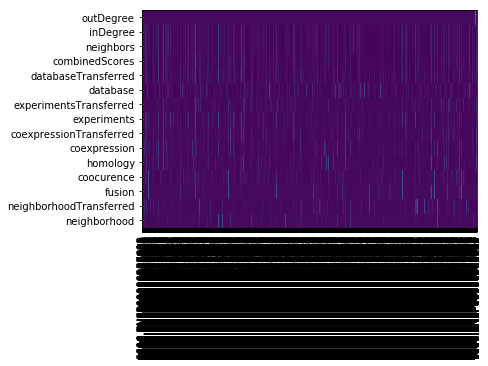

In [21]:
dfVisualization = pd.DataFrame(dataMl.iloc[:,0])
dfNormalization = pd.DataFrame(StandardScaler().fit_transform(dataMl.iloc[:,1:].values), columns = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','delete','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
])
dfVisual = pd.concat([dfVisualization,dfNormalization], axis=1, sort=False).dropna()
del dfVisual["delete"]
#net = Network(clustergrammer_widget)
vis = dfVisual.iloc[:,1:].values
cols = np.array(dfVisual['id'])
ind = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
]
vs = pd.DataFrame(vis.T, index = ind, columns = cols)
vs.T.to_csv('vs_explore.csv')
plt.pcolor(vs)
plt.yticks(np.arange(0.5, len(vs.index), 1), vs.index)
plt.xticks(np.arange(0.5, len(vs.columns), 1), vs.columns, rotation=90)
plt.show()

The visualization above displays the 7000 proteins with its corresponding values. The reader cannot really infer from the plot, how the cancer looks. Thus, below I sliced information in chunks of 25 proteins to be able to compare cancer against regular proteins. 

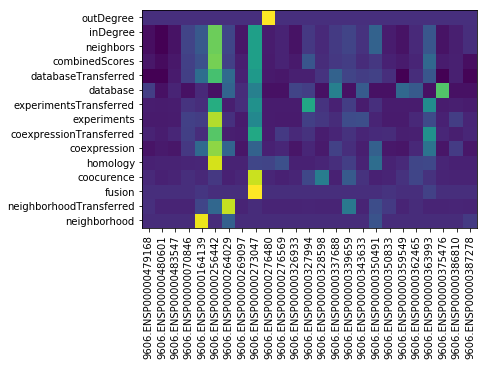

In [22]:
dfVisualization_z = pd.DataFrame(np.array(dataMl.iloc[475:500,0]))
dfNormalization_z = pd.DataFrame(StandardScaler().fit_transform(dataMl.iloc[475:500,1:].values), columns = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','delete','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
])
dfVisual_z = pd.concat([dfVisualization_z,dfNormalization_z], axis=1, sort=False).dropna()
del dfVisual_z["delete"]
#net = Network(clustergrammer_widget)
vis_z = dfVisual_z.iloc[:,1:].values
cols = np.array(dfVisual_z[0])
ind = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
]
vs_z = pd.DataFrame(vis_z.T, index = ind, columns = cols)
plt.pcolor(vs_z)
plt.yticks(np.arange(0.5, len(vs_z.index), 1), vs_z.index)
plt.xticks(np.arange(0.5, len(vs_z.columns), 1), vs_z.columns, rotation=90)
plt.show()

The first chunk of 25 proteins shows clearly the influence of the outDegree feature to detect cancer. In this case protein "9606.ENSP00000276480" was detected as cancer. However, one slice of information does not confirm the visual exploration. Due to this reason, I plotted another two chunks for verification. 

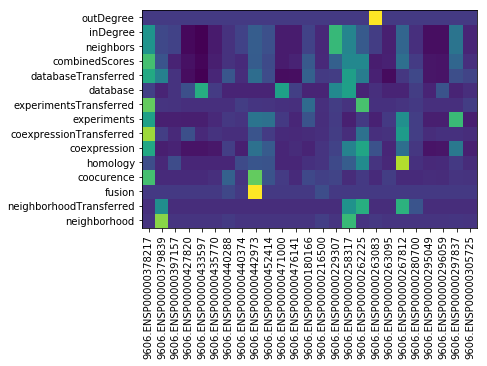

In [23]:
dfVisualization_m = pd.DataFrame(np.array(dataMl.iloc[575:600,0]))
dfNormalization_m = pd.DataFrame(StandardScaler().fit_transform(dataMl.iloc[575:600,1:].values), columns = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','delete','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
])
dfVisual_m = pd.concat([dfVisualization_m,dfNormalization_m], axis=1, sort=False).dropna()
del dfVisual_m["delete"]
#net = Network(clustergrammer_widget)
vis_m = dfVisual_m.iloc[:,1:].values
cols = np.array(dfVisual_m[0])
ind = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
]
vs_m = pd.DataFrame(vis_m.T, index = ind, columns = cols)
plt.pcolor(vs_m)
plt.yticks(np.arange(0.5, len(vs_m.index), 1), vs_m.index)
plt.xticks(np.arange(0.5, len(vs_m.columns), 1), vs_m.columns, rotation=90)
plt.show()

The second chunk of 25 proteins confirms the influence of the outDegree feature to detect cancer. In this case protein "9606.ENSP00000263083" was detected as cancer. 

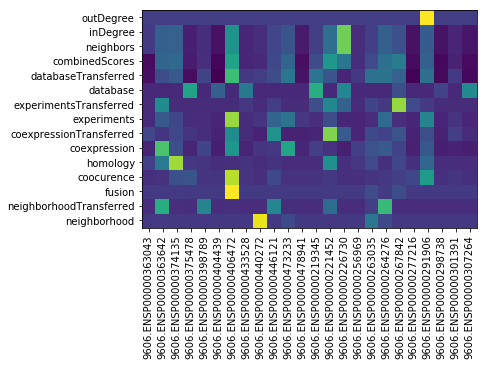

In [24]:
dfVisualization_m = pd.DataFrame(np.array(dataMl.iloc[751:775,0]))
dfNormalization_m = pd.DataFrame(StandardScaler().fit_transform(dataMl.iloc[751:775,1:].values), columns = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','delete','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
])
dfVisual_m = pd.concat([dfVisualization_m,dfNormalization_m], axis=1, sort=False).dropna()
del dfVisual_m["delete"]
#net = Network(clustergrammer_widget)
vis_m = dfVisual_m.iloc[:,1:].values
cols = np.array(dfVisual_m[0])
ind = ['neighborhood','neighborhoodTransferred','fusion','coocurence','homology','coexpression','coexpressionTransferred','experiments','experimentsTransferred','database','databaseTransferred','combinedScores','neighbors','inDegree','outDegree'
]
vs_m = pd.DataFrame(vis_m.T, index = ind, columns = cols)
plt.pcolor(vs_m)
plt.yticks(np.arange(0.5, len(vs_m.index), 1), vs_m.index)
plt.xticks(np.arange(0.5, len(vs_m.columns), 1), vs_m.columns, rotation=90)
plt.show()

The third chunk of 25 proteins again confirms the influence of the outDegree feature to detect cancer. In this case protein "9606.ENSP00000291906" was detected as cancer. 

Overall from the visualization exploration, it is possible to infer the importance of analyzing from the network approach interaction between proteins. In this case I confirm the importance of the outDegree feature to train the machine learning algorithm. 

In [25]:
# initialize network object
net = Network(clustergrammer_widget)
# load dataframe
net.load_df(vs_m)
# cluster using default parameters
net.cluster(enrichrgram=True)
# make the visualization
net.widget()

Y2x1c3RlcmdyYW1tZXJfd2lkZ2V0KG5ldHdvcms9dSd7Im1hdCI6IFtbLTAuMjkzNjQ2NzY2NzM1MDk3MTUsIC0wLjI2MTMzMDM0OTM5NjA3MjgsIC0wLjI5MzY0Njc2NjczNTA5NzE1LCAtMC7igKY=


# Please check the Tableau Report for a complete detail of the data visualization exploration* 

### PCA Component Decision

In this part I am going to verify how many of the features affecting proteins are useful to detect cancer. Thus, the next step is to apply the principal component analysis to create feature reduction. In order to proceed with the PCA, I will need to know which independent variables are more significant in terms of variance. Thanks to the function "explained_variance_ratio", I will check the percentage of variance is represented by each variable. From my personal point of view, I like to reduce the variables up to the point where I am using around 70% of the system variance. 

In [27]:
#dataMlPreprocess = pd.concat([xScaled,pd.DataFrame(dataMl.iloc[:,16])], axis = 1, sort = False)
x_reduced = pd.read_csv('x_scaled_reduced.csv')
y_org = pd.DataFrame(dataMl.iloc[:,16])
#concat I need to erase rows with null values.
cleanReduced = pd.concat([x_reduced,y_org], axis = 1, sort = False).dropna()
x_reduced = cleanReduced.iloc[:,1:-1]
y_reduced = cleanReduced.iloc[:,14]

In [28]:
#Amount of components decision: run pca with all the elements in the x_reduced and analyze the percentage of 
# variance over the dataset with the percentage of variance.
pca = PCA(n_components = 12)
principal = pca.fit_transform(np.array(x_reduced))
x_org_pca = principal 
percentageVarianceVector = pca.explained_variance_ratio_
percentageVarianceVector

array([0.40492173, 0.14731663, 0.11770289, 0.08294932, 0.06559242,
       0.0534369 , 0.03989198, 0.02616999, 0.02424722, 0.01877703,
       0.01612736, 0.00286654])

From the percentage variance vector we can infer that working with 4 components will meet the requirement close to 70%. Thus, I will run the dimensionality reduction with 4 components. After deciding how many components to use, I will proceed with performing the imbalance data check to continue with the pca algorithm.

Use it to check whether the matrix was working properly.
#np.linalg.svd(np.array(x_reduced))

# Dealing with Imbalanced Data

In order to make sure that the predictions are made properly, it is needed to know how our data looks. For example, if we have too few cancer properties, we will need to create a homogeneous dataset in order to test the algorithm. Otherwise, it might be biased due to the skewed data. The same case occurs in the anomaly detection for credit cards fraud, cases where the anomalies turn out to be around 5% or 2% of the total amount of data. 
Therefore, from the Machine Learning Dataset we want to identify how many positive cancer proteins do we have. 

In [29]:
filteredCancer = pd.DataFrame(y_reduced).query("cancer == 1") 
percentageCancer = (filteredCancer.count()/y_reduced.count())*100
percentageCancer
# Cancer = 0.7%

cancer    0.70277
dtype: float64

After filtering the cancer proteins, I found out that only 135 are cancer out of 19518. That makes our data highly imbalanced, only 0.70% of the proteins represent cancer. There will be a need to use SMOTE (Synthetic Minority Over-sampling Technique) to give homogeneity to our dataset. According to [Imbalanced Learning](https://imbalanced-learn.org/en/stable/auto_examples/combine/plot_comparison_combine.html#sphx-glr-auto-examples-combine-plot-comparison-combine-py) we will need to apply the oversampling method to increase our skewed cancer data and an undersampling method to clean the noise generated on data. 

In [30]:
#Perform resample minority
#Increase the skewed cancer data to 20%.
smote = SMOTE(sampling_strategy = 0.2)
x_res, y_res = smote.fit_resample(x_reduced,y_reduced)

In [31]:
#Perform undersample of majority (its a problem to compute such amount of data for the ML algorithm)
under_sampling = RandomUnderSampler(sampling_strategy = 0.4)
x_un, y_un = under_sampling.fit_resample(x_res,y_res)
x_un[0]

array([0.09563056, 0.        , 0.01068802, 0.05931258, 0.02226811,
       0.04049717, 0.01544232, 0.15844042, 0.26243902, 0.10347553,
       0.11500582, 0.09563056, 0.14619726])

### More Data Preprocessing: Rebuilding Dataset After Balancing Data

After resampling, I will check again how the proportions are, and based on the results, change the sample ratios. 

In [32]:
x_rebuild = pd.DataFrame(x_un, columns = ["0","1", "2", "3", "4", "5", "6","7","8","9","10","11","12"])
y_rebuild = pd.DataFrame(y_un, columns = ["cancer"])
rebuildCleanData = pd.concat([x_rebuild, y_rebuild], axis = 1, sort = False)
rebuildCleanData.to_csv("rebuildmachinelearningready.csv")

In [33]:
amount_cancer = len(rebuildCleanData.query("cancer == 1"))
total_data = len(rebuildCleanData)
percentage = (float(amount_cancer)/float(total_data))*100
# cancer = ~28%
percentage

28.574261352369625

After rebuilding the dataset, now we do have a balance cancer / protein information (cancer ~ 30%). Thus, I am able to proceed with the machine learning algorithm.

### Machine Learning Algorithm (Supervised Learning) : SVM for the binary classification

I selected the support vector machine algorithm (SVM) to perform the binary classification over the data set. 

In [34]:
# Separate clean dataset into training set and test set.
x_split = rebuildCleanData.iloc[:,:-1]
y_split = rebuildCleanData.iloc[:,13]
X_train, x_test, Y_train, y_test = train_test_split(x_split,y_split,test_size=0.2,random_state=1)

After applying resampling and spliting the dataset into training set and test set, I will apply the principal component analysis to reduce the independent variables to 4.

In [35]:
pca = PCA(n_components = 4)
x_train_pca = pca.fit_transform(X_train)
x_test_pca = pca.transform(x_test)

In [36]:
# Applying machine learning algorithm
clf = svm.SVC(kernel = 'linear', C=0.01)
y_pred = clf.fit(x_train_pca, Y_train).predict(x_test_pca)

### Evaluation: F - Measure to check accuracy

In [37]:
conf = confusion_matrix(y_test, y_pred)

In [38]:
# Compute Precision and Recall of the algorithm
precision = float(conf[0,0])/float(conf[0,0] + conf[0,1])
recall = float(conf[0,0])/float(conf[1,0] + conf[0,0])

In [39]:
#Compute F-Measure
f_measure = 2*((precision*recall)/(precision + recall)) 

In [40]:
f_measure 
# ~83% The project has pending a cross Validation and a Grid Search to improve performance on the algorithm. (Waiting to work in a laptop.)

0.8388952819332566

# I can do magic with data ! =D

I am aware also of the opportunity areas that this project might have. Which can be discussed over an interview. Nobody is perfect and constructive criticism is always welcome. 